In [136]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import matplotlib.animation as animation

In [137]:
%matplotlib inline

# Problem 1

Consider the initial/boundary value problem

\begin{align}
	\begin{split}
	&{ } u_t = .05 u_{xx}, \quad x \in [0,1], \quad t \in [0,1]\\
	&{ } u(0,t) = 0,\quad u(1,t) = 0,\\
	&{ } u(x,0) = 2\max\{.2 - |x-.5|,0\}.
	\end{split}
\end{align}

Approximate the solution $u(x,t)$ at time $t = .4$ by taking 6 subintervals in the $x$ dimension and 10 subintervals in time.

In [138]:
def heat_func(x, v, t, J, M, f):
    k = t[1] - t[0]
    h = x[1] - x[0]
    
    lmbda = v * k / h**2
    # make A matrix
    A = np.eye(M+1) * (1 - 2*lmbda)
    for i in range(len(A) - 1):
        A[i, i+1] = lmbda
        A[i+1, i] = lmbda
        
    A[0, 0] = 1
    A[-1, -1] = 1
    A[-1, -2] = 0
    A[0, 1] = 0
    
    U = np.zeros((J+1, M+1))
    # get first row
    U[0] = np.array([f(xi) for xi in x])
    
    # get rest of U
    for j in range(1, J+1):
        U[j] = A @ U[j-1]
        
    return U

def plot_Us(domain, U, prob_name):
    fig = plt.figure()
    axs = fig.add_subplot(111)
    traj, = plt.plot([],[])
    traj_analytic, = plt.plot([], [])
    axs.set_xlim(np.min(domain), np.max(domain))
    axs.set_ylim(np.min(U),np.max(U))

    #update function for our U plot
    def update(i):
        traj.set_data(domain, U[i])
    ani = animation.FuncAnimation(fig, update, frames=U.shape[0],interval=50)
    ani.save(prob_name + ".mp4")
    return ani

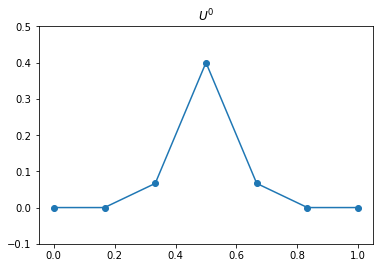

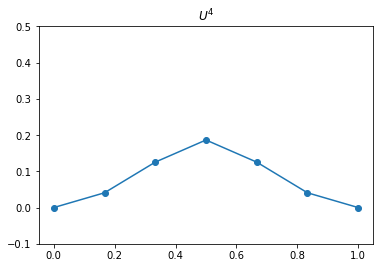

In [139]:
v = .05
a = 0
b = 1
f = lambda x: 2 * max([.2 - abs(x - .5), 0])
x_int = 6
t_int = 10
x = np.linspace(a, b, x_int + 1)
t = np.linspace(0, 1, t_int + 1)

ys = heat_func(x, v, t, t_int, x_int, f)

# Show u0
plt.plot(x, ys[0], marker='o')
plt.ylim(-.1, .5)
plt.title(r'$U^0$')
plt.show()

# Show u4
plt.plot(x, ys[3], marker='o')
plt.ylim(-.1, .5)
plt.title(r'$U^4$')
plt.show()


# Problem 2

Solve the initial/boundary value problem

\begin{align}
	\begin{split}
	&{ } u_t = u_{xx}, \quad x \in [-12,12],\quad t \in [0,1], \\
	&{ } u(-12,t) = 0,\quad u(12,t) = 0,\\
	&{ } u(x,0) = \max\{1 - x^2,0\}
	\end{split}
\end{align}

using the first order explicit method (1.1).
Use 140 subintervals in the $x$ dimension and 70 subintervals in time.
The initial and final states are shown in Figures 1 and 2.
Animate your results.

Explicit methods usually have a stability condition, called a CFL condition (for Courant-Friedrichs-Lewy).
For method (1.1) the CFL condition that must be satisfied is that:

$$\lambda \leq \frac{1}{2}$$

Repeat your computations using 140 subintervals in the $x$ dimension and 66 subintervals in time. Animate the results.
For these values the CFL condition is broken; you should easily see the result of this instability in the approximation $U^{66}$.


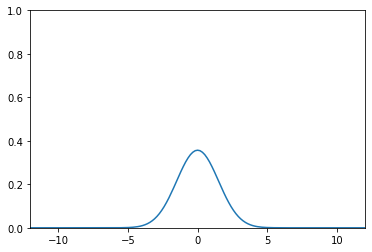

In [140]:
v = 1
a = -12
b = 12
f = lambda x: max([1 - x**2, 0])
x_int = 140
t_int = 70
x = np.linspace(a, b, x_int + 1)
t = np.linspace(0, 1, t_int + 1)

ys = heat_func(x, v, t, t_int, x_int, f)

plot_Us(x, ys, "heat_equation1")
plt.ioff()
print('')

<video src="heat_equation1.mp4" controls>

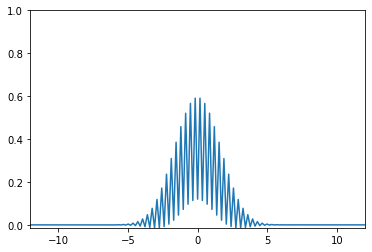

In [141]:
v = 1
a = -12
b = 12
f = lambda x: max([1 - x**2, 0])
x_int = 140
t_int = 66
x = np.linspace(a, b, x_int + 1)
t = np.linspace(0, 1, t_int + 1)

ys = heat_func(x, v, t, t_int, x_int, f)
plt.ioff()
plot_Us(x, ys, "heat_equation2")
print('')

<video src="heat_equation2.mp4" controls>

# Problem 3

Using the Crank Nicolson method, numerically approximate the solution $u(x,t)$ of the problem

\begin{align}
	\begin{split}
	&{ } u_t = u_{xx}, \quad x \in [-12,12],\quad t \in [0,1],\\
	&{ } u(-12,t) = 0,\quad u(12,t) = 0,\\
	&{ } u(x,0) = \max\{1 - x^2,0\}.
	\end{split}
\end{align}

Demonstrate that the numerical approximation at $t = 1$ converges to  $u(x,t=1)$.
Do this by computing $U$ at $t=1$ using $20,40,80,160,320$, and $640$ steps.
Use the same number of steps in both time and space.
Reproduce the loglog plot shown in Figure 4.
The slope of the line there shows the proper rate of convergence.

To measure the error, use the solution with the smallest $h$ (largest number of intervals) as if it were the exact solution, then sample each solution only at the x-values that are represented in the solution with the largest $h$ (smallest number of intervals).
Use the $\infty$-norm on the arrays of values at those points to measure the error.

Notice that, since the Crank-Nicolson method is unconditionally stable, there is no CFL condition and we can use the same number of intervals in time and space.

In [171]:
def heat_cn(nu,f,xbounds,tbounds,xsteps,tsteps):
    """Computes the Crank-Nicholson solution to the heat equation initial/boundary
    value problem:
    
        u_t = νu_xx, x∈[x0,x1] t∈[t0,t1]
        u(x0,t) = 0, u(x1,t) = 0
        u(x,0) = f(x)
    """
    x_domain = np.linspace(xbounds[0], xbounds[1], xsteps + 1)
    t_domain = np.linspace(tbounds[0], tbounds[1], tsteps + 1)

    k = t_domain[1] - t_domain[0]
    h = x_domain[1] - x_domain[0]
    
    lmbda = nu * k / (2 * h**2)
    print(lmbda)
    
    # make A matrix
    A = np.eye(xsteps + 1) * (1 + 2*lmbda)
    for i in range(len(A) - 1):
        A[i, i+1] = -lmbda
        A[i+1, i] = -lmbda
        
    A[0, 0] = 1
    A[-1, -1] = 1
    A[-1, -2] = 0
    A[0, 1] = 0
    
    B = np.eye(xsteps + 1) * (1 - 2*lmbda)
    for i in range(len(A) - 1):
        B[i, i+1] = lmbda
        B[i+1, i] = lmbda
        
    B[0, 0] = 1
    B[-1, -1] = 1
    B[-1, -2] = 0
    B[0, 1] = 0

    U = np.zeros((tsteps+1, xsteps+1))
    # get first row
    U[0] = np.array([f(x) for x in x_domain])

    # get rest of U
    for j in range(1, tsteps+1):
        U[j] = la.solve(B, A @ U[j-1])
                
    return U
                        
f = lambda x: np.max([1 - x**2, 0])
Us = []
hs = [20, 40, 80, 160]
for h in hs:
    Us.append(heat_cn(1, f, (-12, 12), (0, 1), h, h))
    
true_solution = Us[-1]
E = []
for u in Us[:-1]:
    E.append(la.norm(u - true_solution, np.inf))
plt.loglog(hs, E)
plt.loglog(hs,np.array(hs)**2)
plt.legend()
plt.title('Problem 3')

0.017361111111111133
0.034722222222222265
0.06944444444444411
0.13888888888888823


ValueError: operands could not be broadcast together with shapes (21,161) (21,21) 